In [1]:
import numpy as np
from numpy.random import multinomial
import matplotlib.pyplot as plt
import warnings
from __future__ import division
import seaborn as sns
from scipy.stats import bernoulli, beta, binom
%matplotlib inline

In [2]:
def policy(params, method):
    """
    
    1. policy to determine which machine to select
    2. returns 0 or 1
    3. inputs (a1,a2,b1,b2) should be integers
    4. method should be either exploitation, exploration or proportion
    
    """
    
    if method == 'exploit':
        return np.argmax([float(a)/(a+b) for (a,b) in params])
    elif method == 'explore':
        k = len(params)
        return np.argmax(multinomial(1,np.repeat(float(1)/k,k)))
    elif method == 'thompson':
        return np.argmax([beta.rvs(a,b) for (a,b) in params])
    

In [3]:
def thompson_sampler(method, N, K, true_theta):
    """
    Implement Thompson Sampler
    
    Parameters
    -----
    
    method: exploit, explore, thompson
    N: number of iterations of the sampler
    K: number of machine
    
    Returns
    -----
    
    machine: array that holds the winning machine at each iteration
    sum(reward): the total reward
    theta: vector of parameters for each machine
    regret: vector of "rewards" if the machine with the maximum theta was always chosen
    
    """
    
    # remove numpy warnings for indexing with non-integers
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")

        machine = np.empty(N)
        reward = np.empty(N)
        
        regret = np.zeros(N)
        theta = np.ones(2*K).reshape(K,2) # prior is beta(1,1) for each machine

        for t in range(N):

            machine[t] = policy(theta, method)

            # sample reward using true probability
            reward_theta = true_theta[machine[t]]

            # if best machine selected, then regret should be 0
            regret[t] = bernoulli.rvs(max(true_theta))
           
            if reward_theta == max(true_theta):
                reward[t] = regret[t]
            else:
                reward[t] = bernoulli.rvs(reward_theta)

            if reward[t] == 1:
                theta[machine[t]][0] += 1 
            else:
                theta[machine[t]][1] += 1
            
        return machine, reward, theta, regret

In [4]:
"""
UCB1 Algorithm
"""

def UCB1():
    machine_reward = true_theta

    machine_list = np.array(range(K))
    r = np.zeros(K)
    n = np.ones(K)
    mu = r/n

    machine_played = np.zeros(K*(N-K)).reshape((N-K),K)
    machine_wins = np.zeros(K*(N-K)).reshape((N-K),K)
    regret = np.zeros(N-K)

    for t in range(K,N):

        machine = np.argmax(mu + np.sqrt(2*np.log(t)/n))  

        regret[t-K] += bernoulli.rvs(max(machine_reward))

        if machine_reward[machine] == max(machine_reward):
            r[machine] += regret[t-K]
        else:
            r[machine] += bernoulli.rvs(machine_reward[machine])

        n[machine] += 1

        machine_played[t-K] = n
        machine_wins[t-K] = r

        mu[machine] = r[machine]/n[machine]
        
    
    return np.cumsum(regret), np.sum(machine_wins,axis=1), machine_wins, machine_played

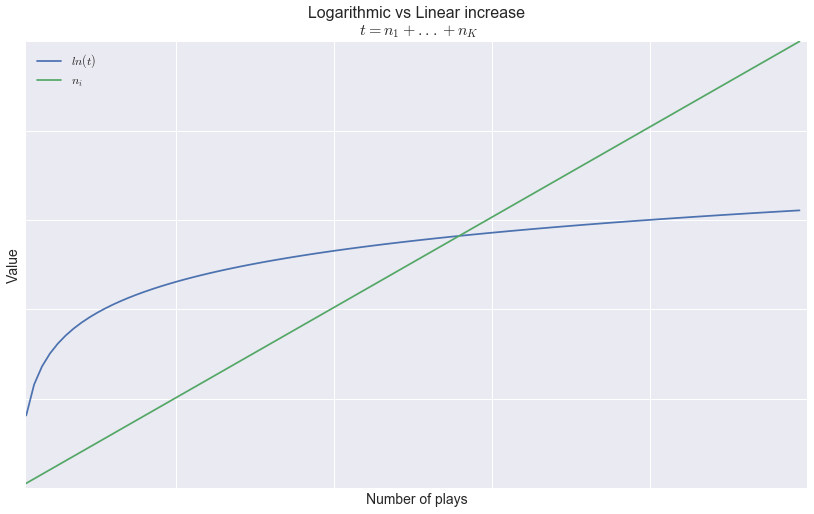

In [5]:
plt.figure(figsize=(14,8))
n1 = np.linspace(0,10,100)
t = n1*50
plt.plot(np.log(t))
plt.plot(n1)
plt.xlim(1,100)
plt.tick_params(
    axis='both',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    labelbottom='off',
    labelleft='off'
)
plt.legend([r'$ln(t)$',r'$n_i$'],loc='best',fontsize=12)
plt.title("Logarithmic vs Linear increase\n " r'$t = n_1 + ... + n_K$',size=16)
plt.xlabel("Number of plays",size=14)
plt.ylabel("Value",size=14)
pass

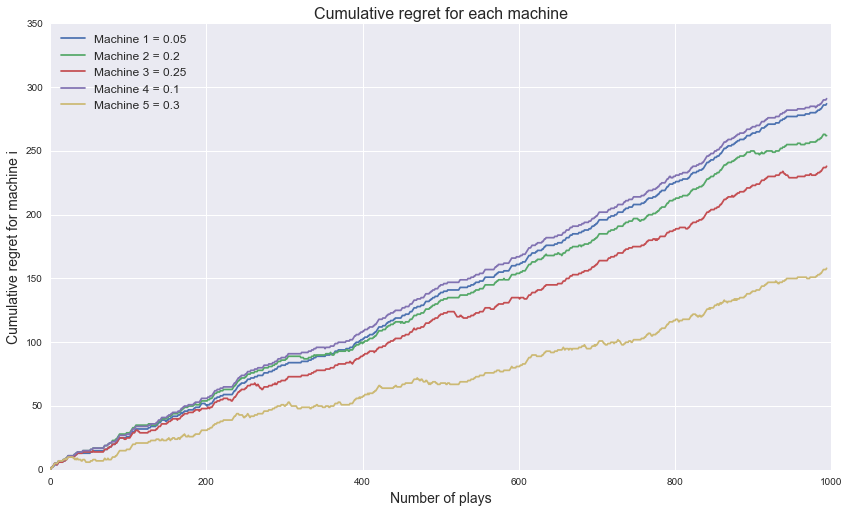

In [6]:
"""
Plot regret for each machine compared against each other
"""
N = 1000
K = 5
T = 30
np.random.seed(112)

true_theta = np.array([0.05,0.20,0.25,0.10,0.30])

ucb_max_1 = UCB1()[0]
ucb_actual_1 = UCB1()[2]

plot_regret = (ucb_max_1 - ucb_actual_1.T).T
plt.figure(figsize=(14,8))
plt.title("Cumulative regret for each machine",size=16)
plt.plot(plot_regret)
plt.legend(['Machine 1 = {}'.format(true_theta[0]),
            'Machine 2 = {}'.format(true_theta[1]),
            'Machine 3 = {}'.format(true_theta[2]),
            'Machine 4 = {}'.format(true_theta[3]),
            'Machine 5 = {}'.format(true_theta[4])],
          loc='best',fontsize=12)
plt.ylabel("Cumulative regret for machine i",size=14)
plt.xlabel("Number of plays",size=14)
plt.ylim(0,350)
            
pass

In [7]:
np.mean([np.sum(UCB1()[2][-1]) for i in range(100)])

228.88

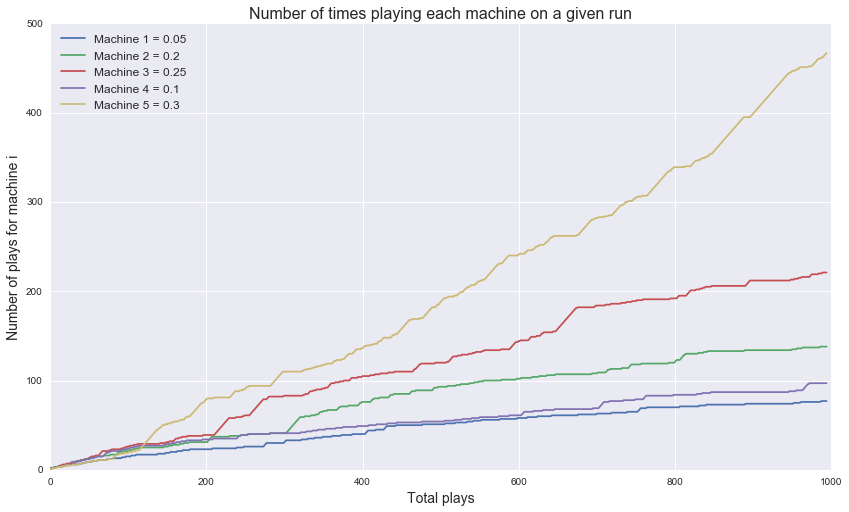

In [8]:
"""
Plot number of times each machine is played for a given run
"""

# ucb_max_1 = 
# ucb_actual_1 = UCB1()[2]

# plot_regret = (ucb_max_1 - ucb_actual_1.T).T

plt.figure(figsize=(14,8))
plt.title("Number of times playing each machine on a given run",size=16)
plt.plot(UCB1()[3])
plt.legend(['Machine 1 = {}'.format(true_theta[0]),
            'Machine 2 = {}'.format(true_theta[1]),
            'Machine 3 = {}'.format(true_theta[2]),
            'Machine 4 = {}'.format(true_theta[3]),
            'Machine 5 = {}'.format(true_theta[4])],
          loc='best',fontsize=12)
plt.ylabel("Number of plays for machine i",size=14)
plt.xlabel("Total plays",size=14)
            
pass